In [1]:
from neo4j import GraphDatabase

url = 'bolt://localhost:7687'
username = 'neo4j'
password = 'letmein'

# Connect to Neo4j
driver = GraphDatabase.driver(url, auth=(username, password))

In [2]:
import pandas as pd

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
run_query("""
RETURN gds.version() 
""")

,gds.version()
0,2.1.6


In [4]:
run_query("""
CREATE CONSTRAINT IF NOT EXISTS ON (s:Stream) ASSERT s.id IS UNIQUE;
""")

""


In [5]:
run_query("""
LOAD CSV WITH HEADERS FROM "https://bit.ly/3JjgKgZ" AS row
MERGE (s:Stream {id: row.id})
SET s.language = row.language
""")

""


In [6]:
run_query("""
USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "https://bit.ly/3S9Uyd8" AS row
MATCH (s:Stream {id:row.source})
MATCH (t:Stream {id:row.target})
MERGE (s)-[r:SHARED_AUDIENCE]->(t)
SET r.weight = toInteger(row.weight)
""")

""


In [7]:
run_query("""
CALL gds.graph.project("twitch", "Stream", 
  {SHARED_AUDIENCE: {orientation: "UNDIRECTED", properties:["weight"]}})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Stream': {'label': 'Stream', 'properties': {}}}",{'SHARED_AUDIENCE': {'orientation': 'UNDIRECTE...,twitch,4079,262854,121


In [8]:
data = run_query("""
CALL gds.beta.node2vec.stream('twitch', 
  {embeddingDimension:8, relationshipWeightProperty:'weight',
   inOutFactor:2, returnFactor:1})
YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) AS node, embedding
RETURN node.id AS streamId, node.language AS language, embedding
""")
data['output'] = pd.factorize(data['language'])[0]


In [9]:
data.head()

,streamId,language,embedding,output
0,129004176,en,"[0.3278140425682068, 0.33119747042655945, -1.8...",0
1,26490481,en,"[-0.06879238039255142, -0.213059663772583, -0....",0
2,213749122,en,"[-0.47573158144950867, 1.0394240617752075, -0....",0
3,30104304,en,"[0.061862602829933167, 0.6043638586997986, -0....",0
4,160504245,en,"[0.4287364184856415, 0.41089189052581787, -0.4...",0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data['embedding'].to_list()
y = data['output'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)



RandomForestClassifier()

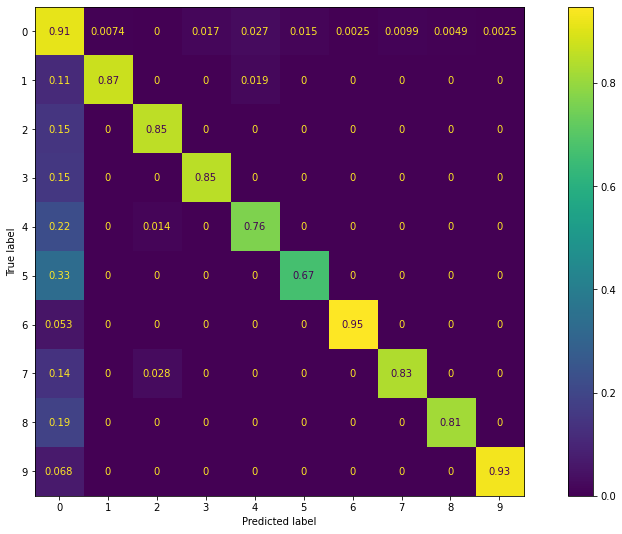

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rfc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize= 'true')

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88       406
           1       0.94      0.87      0.90        54
           2       0.95      0.85      0.90        48
           3       0.88      0.85      0.86        59
           4       0.82      0.76      0.79        72
           5       0.85      0.67      0.75        51
           6       0.95      0.95      0.95        19
           7       0.88      0.83      0.86        36
           8       0.92      0.81      0.86        27
           9       0.98      0.93      0.95        44

    accuracy                           0.87       816
   macro avg       0.90      0.84      0.87       816
weighted avg       0.87      0.87      0.87       816



In [13]:
run_query("""
CALL gds.graph.drop('twitch')
""")

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,twitch,neo4j,,-1,4079,262854,{'relationshipProjection': {'SHARED_AUDIENCE':...,0.015802,2022-08-03T18:13:09.561909000+02:00,2022-08-03T18:13:09.680269000+02:00,"{'graphProperties': {}, 'relationships': {'SHA..."
